In [54]:
import sys
sys.path.append("..")
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
from scipy import optimize
from torch.utils.data import DataLoader, Dataset
from data_loaders import *
import missing_process.missing_method as missing_method
from missing_process.block_rules import *
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
datalist = ["banknote","concrete_compression",
            "wine_quality_white","wine_quality_red",
            "california","climate_model_crashes",
            "connectionist_bench_sonar","qsar_biodegradation",
            "yeast","yacht_hydrodynamics"
            ]


## Scaler

In [56]:
def minmax_scaler(array,column_min,column_max):
    scaled_array = (array - column_min + 1e-10)  / (column_max - column_min + 1e-10)
    
    return np.round(scaled_array,10)

## Missing Mechs

In [57]:
def MCAR(observed_values, missing_ratio = 0.5,masks = None):
    " Parameters: Input array, missing ratio and an empty mask array "
    " as missing ratio increase, the missing value is increase"
    " True -> not missing, False -> missing"
    " return a fixed mask array"
    for col in range(observed_values.shape[1]):  # col #

        obs_indices = np.where(observed_values[:, col])[0] # list all index for each columns
        miss_indices = np.random.choice(
        obs_indices, round(len(obs_indices) * missing_ratio), replace=False # random select some columns
        )
        masks[miss_indices, col] = False
    return masks

In [58]:
def diffuse_mnar_single(data, up_percentile = 0.5, obs_percentile = 0.5):
    " Parameters: Input array, up_percentile for missing columns, obs_percentile for obs columns"
    " Only have half of column have missing value, for any missing columns we will select a obs columns for it, the result is depend on both missing and observe part"
    " 1 -> not missing, 0 -> missing"
    " return a mask"
    np.random.seed(1)

    def scale_data(data):
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        scaled_data = (data - min_vals) / (max_vals - min_vals)
        return scaled_data
    

    data = scale_data(data)

    mask = np.ones(data.shape)

    n_cols = data.shape[1]
    n_miss_cols = int(n_cols * 0.5)  # 选择50%的列作为缺失列
    miss_cols = np.random.choice(n_cols, size=n_miss_cols, replace=False)  # 随机选择缺失列的索引
    #print(miss_cols)

    obs_cols = [col for col in range(data.shape[1]) if col not in miss_cols]
    
    for miss_col in miss_cols:
        missvar_bounds = np.quantile(data[:, miss_col], up_percentile)
        temp = data[:, miss_col] > missvar_bounds
        
        obsvar_bounds = np.quantile(data[temp][:, obs_cols], obs_percentile)
        temp2 = data[:, miss_col] > obsvar_bounds



        merged_temp = np.logical_or(temp, temp2).astype(int)
        mask[:, miss_col] = merged_temp
    #print("Missing Rate",1 - np.count_nonzero(mask) / mask.size)
    return mask

## Process Function

In [59]:
def process_func(dataname, path = None, aug_rate=1,missing_type = "MCAR",
                  missing_para = None):
    
    if dataname not in datalist:
        observed_values = path.astype("float32")
        directory_path = f"datasets/{dataname}/"
        
          
        if os.path.exists(directory_path):
            print(f"Directory '{directory_path}' created successfully.")
        else:
            os.makedirs(directory_path, exist_ok=True)
            print(f"Create directory '{directory_path}'.")

    else:
        data = dataset_loader(dataname)
        observed_values = data["data"].astype("float32")

    observed_masks = ~np.isnan(observed_values)
    masks = observed_masks.copy()


    "Need input origin dataset and parameters"
    if missing_type == "MCAR":
        masks = MCAR(observed_values,0.2,masks)


    elif missing_type == "quantile":
        Xnan, Xz = missing_method.missing_by_range(observed_values, missing_para)
        masks = np.array(~np.isnan(Xnan), dtype=np.float)

    elif missing_type == "logistic":
        masks = missing_method.MNAR_mask_logistic(observed_values, missing_para)

    elif missing_type == "diffuse":
        masks = diffuse_mnar_single(observed_values, missing_para[0],missing_para[1])

    # gt_mask: 0 for missing elements and manully maksed elements
    gt_masks = masks.reshape(observed_masks.shape)

    observed_values = np.nan_to_num(observed_values)
    observed_masks = observed_masks.astype(int)
    gt_masks = gt_masks.astype(int)

    return observed_values, observed_masks, gt_masks, observed_values.shape[1]

## Sensitivity check

In [60]:
def sensitivity_check(observed_values,gt_masks):
    zero_percentage = (gt_masks == 0).mean() * 100

    print(f"Missing Rate initial load: {zero_percentage:.4f}%")

    min_values = np.min(observed_values, axis=0)
    max_values = np.max(observed_values, axis=0)

    min_check = np.any(min_values > 1) or np.any(min_values < 0)
    max_check = np.any(max_values > 1) or np.any(max_values < 0)
    
    print("Min Values:", min_values)
    print("Max Values:", max_values)
    
    if min_check or max_check:
        print("Test did not pass: Min or Max values out of range")
    else:
        print("Test passed: Min and Max values are within range")

## Create data class

In [208]:
class tabular_dataset(Dataset):
    # eval_length should be equal to attributes number.
    def __init__(
        self, dataname, data_path = None, use_index_list=None, 
        aug_rate=1, seed=0,
        missing_type = "MCAR", missing_para = "",missing_name = "MCAR",nosplit = False
        ):
        #self.eval_length = eval_length
        np.random.seed(seed)
        if data_path is None:
            
            dataset_path = f"datasets/{dataname}/data.csv"
        else:
            dataset_path = data_path


        processed_data_path = (
            f"datasets/{dataname}/{missing_type}-{missing_name}_seed-{seed}.pk"
        )

        if not nosplit:
            processed_data_path_norm = (
            f"datasets/{dataname}/{missing_type}-{missing_name}_seed-{seed}_max-min_norm.pk"
            )
        else:
            processed_data_path_norm = (
            f"datasets/{dataname}/{missing_type}-{missing_name}_seed-{seed}_max-min_norm_nosplit.pk"
        )
        

        # If no dataset created
        if not os.path.isfile(processed_data_path):
            print("--------NO Dataset load--------")
            self.observed_values, self.observed_masks, self.gt_masks, self.eval_length = process_func(
                dataname, dataset_path, aug_rate=aug_rate,
                missing_type = missing_type, missing_para = missing_para
            )
            with open(processed_data_path, "wb") as f:
                pickle.dump(
                    [self.observed_values, self.observed_masks, self.gt_masks, self.eval_length], f
                )
            print("--------Dataset created [Unnormalized]--------")

        elif os.path.isfile(processed_data_path) and os.path.isfile(processed_data_path_norm):
            print("--------Have Both Dataset--------")
            with open(processed_data_path_norm, "rb") as f:
                self.observed_values, self.observed_masks, self.gt_masks, self.eval_length = pickle.load(
                    f
                )

            print("--------Normalized Dataset loaded--------")


        elif os.path.isfile(processed_data_path_norm):
            print("--------Only Have Norm Dataset--------")
            with open(processed_data_path_norm, "rb") as f:
                self.observed_values, self.observed_masks, self.gt_masks, self.eval_length = pickle.load(
                    f
                )
            print("--------Normal Dataset loaded--------")

        else:
            with open(processed_data_path, "rb") as f:
                self.observed_values, self.observed_masks, self.gt_masks, self.eval_length = pickle.load(
                    f
                )
            


        # #计算0的占比
        # zero_percentage = (self.gt_masks == 0).mean() * 100

        # print(f"Missing Rate initial load: {zero_percentage:.4f}%")
        
        if use_index_list is None:
            self.use_index_list = np.arange(len(self.observed_values))
        else:
            self.use_index_list = use_index_list

    def __getitem__(self, org_index):
        index = self.use_index_list[org_index]
        s = {
            "observed_data": self.observed_values[index],
            "observed_mask": self.observed_masks[index],
            "gt_mask": self.gt_masks[index],
            "timepoints": np.arange(self.eval_length),
        }
        return s

    def __len__(self):
        return len(self.use_index_list)

In [266]:
def apply_norm(dataset,index,file_name):
    col_num = dataset.observed_values.shape[1]
    max_arr = np.zeros(col_num)
    min_arr = np.zeros(col_num)

    # find the max and min without missing value
    for k in range(col_num):

        # Using observed_mask to avoid counting missing values.
        mask_col = dataset.gt_masks[index, k].astype(bool)
        temp_col = dataset.observed_values[index, k]


        filtered_temp_col = temp_col[mask_col]


        max_arr[k] = max(filtered_temp_col)
        min_arr[k] = min(filtered_temp_col)
    
    

    min_values = np.min(dataset.observed_values, axis=0)
    max_values = np.max(dataset.observed_values, axis=0)

    if np.array_equal(max_arr, max_values):
        print("Max Arrays are equal.")
    else:
        print("Max Arrays are not equal.")
        print(max_arr)
        print(max_values)


    if np.array_equal(min_arr, min_values):
        print("Min Arrays are equal.")
    else:
            print("Min Arrays are not equal.")


    dataset.observed_values = (
    # update normalizaztion
        minmax_scaler(dataset.observed_values,min_arr,max_arr))  * dataset.observed_masks

    with open(file_name, "wb") as f:
        pickle.dump(
            [dataset.observed_values, dataset.observed_masks, dataset.gt_masks, dataset.eval_length], f
        )
        print("--------Normalized Dataset created--------")

## Generate missing value

In [63]:
def get_dataloader(dataname, seed=1, nfold=5, batch_size=16,
                   missing_type = "MCAR", missing_para = "", missing_name = "MCAR", nosplit=False, data_path = None):
    """"
    Apply missing rules
    Nosplit: False-> using trainset, True->using full dataset
    """

    # load initial dataset
    print("Load data")
    dataset = tabular_dataset(dataname = dataname,seed=seed,data_path = data_path,
                              missing_type = missing_type, missing_para = missing_para,
                                missing_name = missing_name, nosplit = nosplit)

    
    indlist = np.arange(len(dataset))

    np.random.seed(seed + 1)
    np.random.shuffle(indlist)

    tmp_ratio = 1 / nfold
    start = (int)((nfold - 1) * len(dataset) * tmp_ratio)
    
    end = (int)(nfold * len(dataset) * tmp_ratio)

    test_index = indlist[start:end]
    remain_index = np.delete(indlist, np.arange(start, end))

    np.random.shuffle(remain_index)

    # Modify here to change train,valid ratio
    num_train = (int)(len(remain_index) * 0.9)
    train_index = remain_index[:num_train]
    valid_index = remain_index[num_train:]

    save_index = {}
    save_index["test_index"] = test_index.astype(np.int64).tolist()
    save_index["train_index"] = train_index.astype(np.int64).tolist()
    save_index["valid_index"] = valid_index.astype(np.int64).tolist()
    with open(f"datasets/{dataname}/{missing_type}-{missing_name}_seed-{seed}_index.json", 'w') as file:
        json.dump(save_index, file)

    
    if not nosplit:
        processed_data_path_norm = (
            f"datasets/{dataname}/{missing_type}-{missing_name}_seed-{seed}_max-min_norm.pk"
        )
        if not os.path.isfile(processed_data_path_norm):
            print("--------Need Normalization--------")
            apply_norm(dataset,train_index,processed_data_path_norm)
            


    else:
        processed_data_path_norm = (
        f"datasets/{dataname}/{missing_type}-{missing_name}_seed-{seed}_max-min_norm_nosplit.pk"
    )
        if not os.path.isfile(processed_data_path_norm):
            print("--------Need Normalization--------")
            apply_norm(dataset,indlist,processed_data_path_norm)
    
    
    sensitivity_check(dataset.observed_values,dataset.gt_masks)
    
    


## Start Run

In [12]:
datalist = ["banknote","concrete_compression",
            "wine_quality_white","wine_quality_red",
            "california","climate_model_crashes",
            "connectionist_bench_sonar","qsar_biodegradation",
            "yeast","yacht_hydrodynamics"
            ]

datalist = ["yeast"]


missingtypelist = ["quantile","diffuse","logistic"]


missingtypelist = ["quantile"]

In [36]:
# seed = 1
# nfold = 5


# for dataset in tqdm(datalist):
    
#     for missingtype in missingtypelist:
#         if missingtype == "logistic":
#             missing_rule = load_json_file("missing_rate.json")
#         elif missingtype == "diffuse":
#             missing_rule = load_json_file("diffuse_ratio.json")
#         elif missingtype == "quantile":
#             missing_rule = load_json_file("quantile_full.json")
        

#         for rule_name in missing_rule:
            
#             rule = missing_rule[rule_name]

#             # Create folder
#             # Every loader contains "observed_data", "observed_mask", "gt_mask", "timepoints"
#             print(dataset,missingtype,rule_name)
#             get_dataloader(
#                     dataname=dataset,
#                     seed=seed,
#                     nfold=nfold,
#                     batch_size=128,
#                     missing_type = missingtype,
#                     missing_para = rule,
#                     missing_name = rule_name,
#                     nosplit=True
#                 )


### Analysis of effect of dealing with the distribution

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define the dimensions of the 2D array
rows = 1000
cols = 8  # Set to 8 columns
np.random.seed(1) 
# Create an empty array to store the data
random_array = np.empty((rows, cols))

# Create normal distributions for the first two columns
for i in range(2):
    mean = np.random.uniform(-10, 10)
    std_dev = np.random.uniform(0.1, 5)
    random_array[:, i] = np.random.normal(mean, std_dev, size=rows)

# Create discrete distributions for columns 3-4 with variable outcomes
for i in range(2, 4):
    if i == 2:
        outcomes = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5]
    else:
        outcomes = [1,1,1, 2, 2, 3, 3, 3, 4,]
    random_array[:, i] = np.random.choice(outcomes, size=rows)

# Create skewed distributions for columns 5-6
for i in range(4, 6):
    skewness = np.random.uniform(-100, 100)
    random_array[:, i] = stats.skewnorm.rvs(skewness, size=rows)

# Create mixed normal distributions for columns 7-8
for i in range(6, 8):
    if i % 2 == 0:
        # Create a normal distribution with mode at 2
        normal_dist1 = np.random.normal(2, 1, size=rows)
        normal_dist2 = np.random.normal(6, 0.5, size=rows)  # Additional normal distribution
        random_array[:, i] = np.random.choice(np.concatenate([normal_dist1, normal_dist2]), size=rows)
    else:
        # Create a normal distribution with mode at -2
        normal_dist1 = np.random.normal(-2, 3, size=rows)
        normal_dist2 = np.random.normal(-6, 0.5, size=rows)  # Additional normal distribution
        random_array[:, i] = np.random.choice(np.concatenate([normal_dist1, normal_dist2]), size=rows)

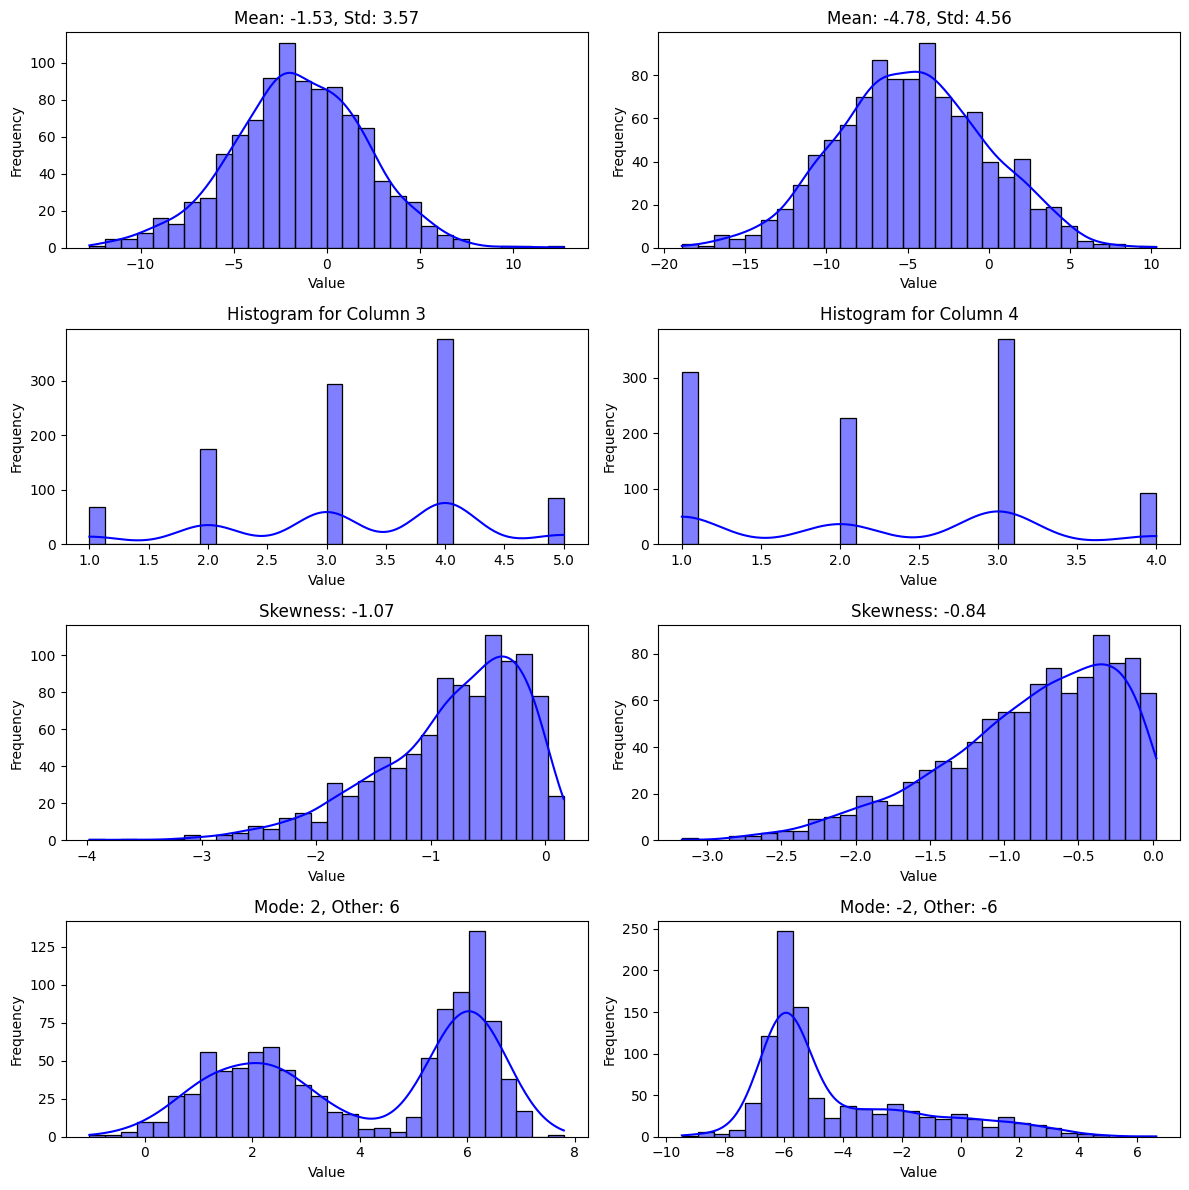

In [264]:
# Create a 4x2 grid of subplots
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.ravel()  # Flatten the 4x2 grid for easy iteration

# Loop through the columns and create histograms and KDE plots
for i in range(cols):
    data_column = random_array[:, i]

    # Histogram
    #axes[i].hist(data_column, bins=30, alpha=0.7, edgecolor='black',kde = True)
    sns.histplot(data=data_column, bins=30, color='blue', ax=axes[i], kde=True)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram for Column {i+1}')

    # # KDE Plot
    # sns.kdeplot(data_column, color='green', shade=True, ax=axes[i])
    # axes[i].set_xlabel('Value')
    # axes[i].set_ylabel('Density')

    # Add subtitles
    if i < 2:
        axes[i].set_title(f'Mean: {np.mean(data_column):.2f}, Std: {np.std(data_column):.2f}')
    elif 3 < i < 6:
        axes[i].set_title(f'Skewness: {stats.skew(data_column):.2f}')
    elif 6 <= i:
        # Extract parameters for mixed normal distributions
        if i % 2 == 0:
            mode_param = 2
            other_param = 6
        else:
            mode_param = -2
            other_param = -6
        axes[i].set_title(f'Mode: {mode_param}, Other: {other_param}')

# Adjust the layout
plt.tight_layout()
plt.show()


In [267]:
for missingtype in missingtypelist:
    if missingtype == "logistic":
        missing_rule = load_json_file("missing_rate.json")
    elif missingtype == "diffuse":
        missing_rule = load_json_file("diffuse_ratio.json")
    elif missingtype == "quantile":
        missing_rule = load_json_file("quantile_full.json")
    
    
    for rule_name in missing_rule:
        rule = missing_rule[rule_name]

        # Create folder
        # Every loader contains "observed_data", "observed_mask", "gt_mask", "timepoints"
        print(missingtype,rule_name)
        get_dataloader(
                dataname="syn1",
                seed=seed,
                nfold=nfold,
                batch_size=128,
                missing_type = missingtype,
                missing_para = rule,
                missing_name = rule_name,
                nosplit=True,
                data_path = random_array,   
            )
        print()


quantile Q1_Q2_0.25
Load data
--------Have Both Dataset--------
--------Normalized Dataset loaded--------
Missing Rate initial load: 11.1375%
Min Values: [ 0.           0.           0.           0.           0.
  0.          -0.050549274  0.         ]
Max Values: [1. 1. 1. 1. 1. 1. 1. 1.]
Test did not pass: Min or Max values out of range

quantile Q1_Q3_0.25
Load data
--------Have Both Dataset--------
--------Normalized Dataset loaded--------
Missing Rate initial load: 10.2000%
Min Values: [ 0.           0.           0.           0.           0.
  0.          -0.050549274  0.         ]
Max Values: [1. 1. 1. 1. 1. 1. 1. 1.]
Test did not pass: Min or Max values out of range

quantile Q1_Q4_0.25
Load data
--------Have Both Dataset--------
--------Normalized Dataset loaded--------
Missing Rate initial load: 10.7750%
Min Values: [ 0.           0.           0.           0.           0.
  0.          -0.050549274  0.         ]
Max Values: [1.1000062155 1.           1.           1.           1